# Part II Model Calibration

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import scipy as sp
from scipy.optimize import brentq
from scipy import interpolate
import matplotlib.pylab as plt
import datetime as dt
from scipy.optimize import least_squares
import array

In [36]:
# Black-Scholes Model

def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [37]:
# Displaced-Diffusion Model

def DisplacedDiffusionCall(F, K, r, sigma, T, beta):
    d1 = (np.log(F/beta/(K+((1-beta)/beta)*F))+(r+(sigma*beta)**2/2)*T) / ((sigma*beta)*np.sqrt(T))
    d2 = d1 - (sigma*beta)*np.sqrt(T)
    return F/beta*norm.cdf(d1) - (K+((1-beta)/beta)*F)*np.exp(-r*T)*norm.cdf(d2)

def DisplacedDiffusionPut(F, K, r, sigma, T, beta):
    d1 = (np.log(F/beta/(K+((1-beta)/beta)*F))+(r+(sigma*beta)**2/2)*T) / ((sigma*beta)*np.sqrt(T))
    d2 = d1 - (sigma*beta)*np.sqrt(T)
    return (K+((1-beta)/beta)*F)*np.exp(-r*T)*norm.cdf(-d2) - F/beta*norm.cdf(-d1)

In [38]:
# Bachelier Model

def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))

In [39]:
# Implied European Options Volatility Model

def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

In [40]:
# SABR Model

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


In [41]:
# DataFrame Import

spx_df = pd.read_csv('SPX_options.csv')
spy_df = pd.read_csv('SPY_options.csv')
rate_df = pd.read_csv('zero_rates_20201201.csv')
rate_df['rate'] = rate_df['rate']/100

# SPX General Data
spx_df = pd.read_csv('SPX_options.csv')
spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2

# SPX Maturity Data
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

In [42]:
# Common parameters
today = dt.date(2020, 12, 1)
maturity_dates = [dt.date(2020, 12, 18), dt.date(2021, 1, 15), dt.date(2021, 2, 19)]

# Calculate Time To Maturity
Ts = [(exdate - today).days / 365.0 for exdate in maturity_dates]
T1, T2, T3 = Ts[:3]

# Discount Rate Interpolation
x = rate_df['days']
y = rate_df['rate']
f = interpolate.interp1d(x,y)
rs = [f(T * 365) / 100 for T in Ts]
r1, r2, r3 = rs[:3]

# Underlying Value & ATM Strike Price
S = 3662.45
K = 3660

# Steps Parameter (American Options)
steps = 20

In [43]:
# Define function to calculate atm volatility
def calculate_atm_volatility(spx, K, r, S, T):
    atm_call = spx[(spx.strike_price == K) & (spx.cp_flag == "C")]
    atm_put = spx[(spx.strike_price == K) & (spx.cp_flag == "P")]
    sigma_call = impliedCallVolatility(S, K, r, atm_call.mid_price, T)
    sigma_put = impliedPutVolatility(S, K, r, atm_put.mid_price, T)
    return (sigma_call + sigma_put) / 2

# Calculate At The Money Volatility for different maturities
sigma1 = calculate_atm_volatility(spx1, K, r1, S, T1)
sigma2 = calculate_atm_volatility(spx2, K, r2, S, T2)
sigma3 = calculate_atm_volatility(spx3, K, r3, S, T3)


In [44]:
sigma1, sigma2, sigma3

(0.17509846325796008, 0.1853573982368258, 0.19093793607663545)

## Displaced Diffusion Model

In [45]:
# Beta Parameter (Displaced-Diffusion Model)
beta_values = [0.8, 0.6, 0.4, 0.2]

def process_spx_data(spx_data):
    spx_call = spx_data[spx_data.cp_flag == "C"].reset_index(drop=True)
    spx_put = spx_data[spx_data.cp_flag == "P"].reset_index(drop=True)
    strike = spx_put["strike_price"].values
    return spx_call, spx_put, strike

spx_call1, spx_put1, strike1 = process_spx_data(spx1)
spx_call2, spx_put2, strike2 = process_spx_data(spx2)
spx_call3, spx_put3, strike3 = process_spx_data(spx3)


In [46]:
# Define function to calculate DD implied vols

def calculate_implied_vols_dd(S, r, T, spx_call, spx_put, strike, sigma, beta_values):
    summary = []
    for i in range(len(spx_put.index)):
        K = strike[i]
        if K <= int(S):
            impliedvol_market = impliedPutVolatility(S, K, r, spx_put['mid_price'][i], T)
            price_lognormal = BlackScholesPut(S, K, r, sigma, T)
            impliedvol_lognormal = impliedPutVolatility(S, K, r, price_lognormal, T)
            price_normal = BachelierPut(S, K, r, sigma, T)
            impliedvol_normal = impliedPutVolatility(S, K, r, price_normal, T)
        else:
            impliedvol_market = impliedCallVolatility(S, K, r, spx_call['mid_price'][i], T)
            price_lognormal = BlackScholesCall(S, K, r, sigma, T)
            impliedvol_lognormal = impliedCallVolatility(S, K, r, price_lognormal, T)
            price_normal = BachelierCall(S, K, r, sigma, T)
            impliedvol_normal = impliedCallVolatility(S, K, r, price_normal, T)
        
        implied_volatilities = []
        for beta in beta_values:
            price_dd = DisplacedDiffusionPut(S, K, r, sigma, T, beta) if K <= int(S) else DisplacedDiffusionCall(S, K, r, sigma, T, beta)
            impliedvol_dd = impliedPutVolatility(S, K, r, price_dd, T) if K <= int(S) else impliedCallVolatility(S, K, r, price_dd, T)
            implied_volatilities.append(impliedvol_dd)
        
        summary.append([K, impliedvol_market, impliedvol_lognormal, impliedvol_normal] + implied_volatilities)
    
    return pd.DataFrame(summary, columns=['strike', 'impliedvol_market', 'impliedvol_lognormal', 'impliedvol_normal'] + [f'impliedvol_dd{beta}' for beta in beta_values])


# Call the function for each set of data
dd_1 = calculate_implied_vols_dd(S, r1, T1, spx_call1, spx_put1, strike1, sigma1, beta_values)
dd_2 = calculate_implied_vols_dd(S, r2, T2, spx_call2, spx_put2, strike2, sigma2, beta_values)
dd_3 = calculate_implied_vols_dd(S, r3, T3, spx_call3, spx_put3, strike3, sigma3, beta_values)



In [47]:
dd_1

,strike,impliedvol_market,impliedvol_lognormal,impliedvol_normal,impliedvol_dd0.8,impliedvol_dd0.6,impliedvol_dd0.4,impliedvol_dd0.2
0,100.0,4.685244,0.000001,0.648660,0.000001,0.000001,0.511999,0.583206
1,200.0,3.741118,0.000001,0.538803,0.000001,0.364790,0.428803,0.486037
2,300.0,3.204715,0.000001,0.477405,0.000001,0.328479,0.383020,0.432059
3,400.0,2.830250,0.000001,0.435436,0.000001,0.304325,0.352136,0.395354
4,500.0,2.542898,0.000001,0.403921,0.000001,0.286619,0.329216,0.367920
...,...,...,...,...,...,...,...,...
406,5000.0,0.436270,0.175098,0.149262,0.170132,0.165074,0.159917,0.154650
407,5100.0,0.461597,0.175098,0.147713,0.169847,0.164493,0.159027,0.153439
408,5200.0,0.486307,0.175098,0.146205,0.169570,0.163929,0.158164,0.152262
409,5300.0,0.486565,0.175098,0.144737,0.169302,0.163381,0.157325,0.151117


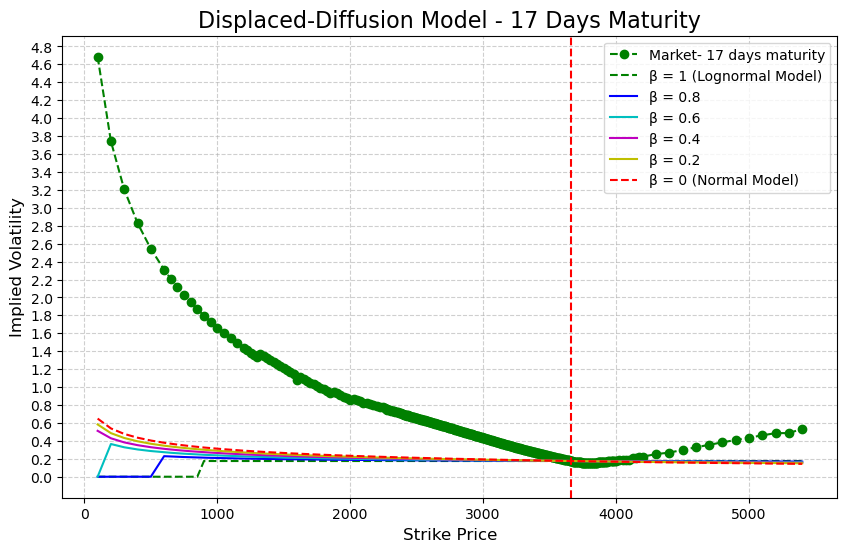

In [48]:
def plotDdGraph(dd, T, color, marker, S):
    plt.figure(figsize=(10, 6))
    plt.plot(dd['strike'], dd['impliedvol_market'], label=f"Market- {T} days maturity", linestyle='--', marker=marker, color=color)
    plt.plot(dd['strike'], dd['impliedvol_lognormal'], 'g--', label='β = 1 (Lognormal Model)')
    plt.plot(dd['strike'], dd['impliedvol_dd0.8'], 'b-', label='β = 0.8')
    plt.plot(dd['strike'], dd['impliedvol_dd0.6'], 'c-', label='β = 0.6')
    plt.plot(dd['strike'], dd['impliedvol_dd0.4'], 'm-', label='β = 0.4')
    plt.plot(dd['strike'], dd['impliedvol_dd0.2'], 'y-', label='β = 0.2')
#     plt.plot(dd['strike'], dd['impliedvol_dd-20'], 'y-', label='β = -20')
    plt.plot(dd['strike'], dd['impliedvol_normal'], 'r--', label='β = 0 (Normal Model)')

    plt.title(f"Displaced-Diffusion Model - {T} Days Maturity", fontsize=16)
    plt.xlabel('Strike Price', fontsize=12)
    plt.ylabel('Implied Volatility', fontsize=12)

    plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust the legend for better readability
    plt.legend(loc='upper right')

    # Set the y-axis ticks at intervals of 0.2
    y_max = dd['impliedvol_market'].max()
    plt.yticks(np.arange(0, y_max+0.2, 0.2))  # Adjust the range and interval as needed

    # Add a vertical line at the S&P 500 index price in red
    plt.axvline(S, color='red', linestyle='--')

    plt.show()
    
plotDdGraph(dd_1,17,'green','o',S)


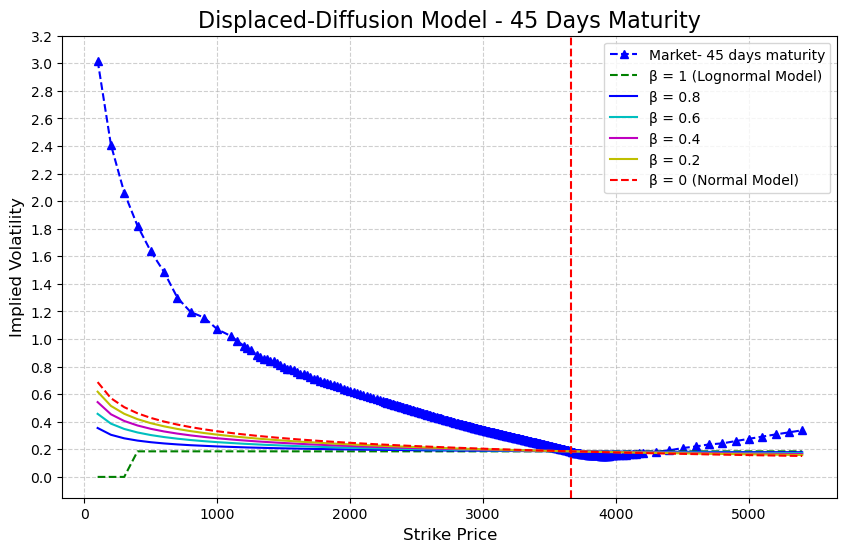

In [49]:
plotDdGraph(dd_2,45,'blue','^',S)

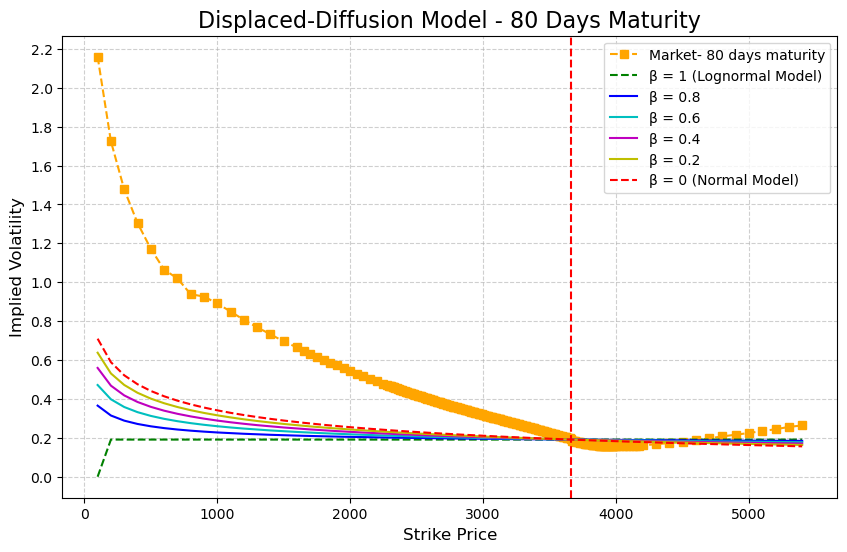

In [50]:
plotDdGraph(dd_3, 80, 'orange', 's',S)

## Implied Volatility (Maturity Comparison)

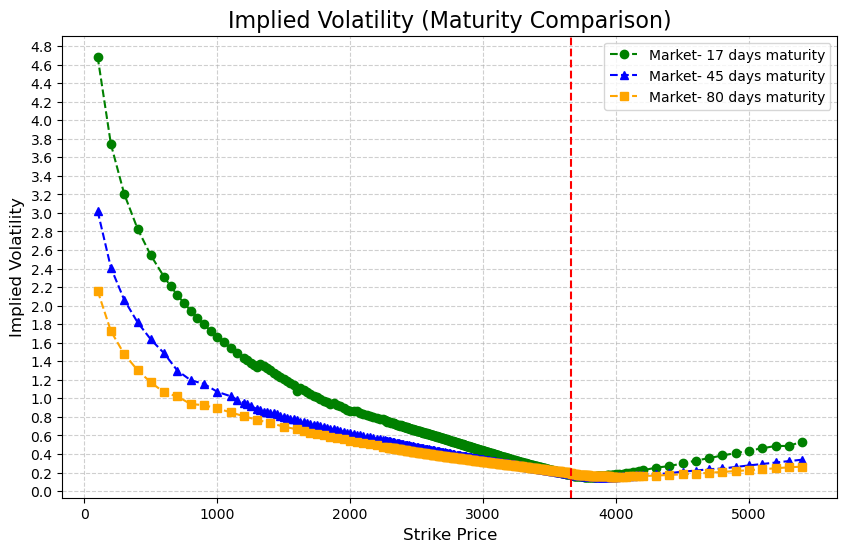

In [51]:
plt.figure(figsize=(10 , 6))

plt.plot(dd_1['strike'], dd_1['impliedvol_market'], label=f"Market- 17 days maturity", linestyle='--', marker='o', color='green')
plt.plot(dd_2['strike'], dd_2['impliedvol_market'], label=f"Market- 45 days maturity", linestyle='--', marker='^', color='blue')
plt.plot(dd_3['strike'], dd_3['impliedvol_market'], label=f"Market- 80 days maturity", linestyle='--', marker='s', color='orange')

plt.title('Implied Volatility (Maturity Comparison)', color = 'k', fontsize=16)
plt.xlabel('Strike Price', fontsize=12)
plt.ylabel('Implied Volatility', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

# Adjust the legend for better readability
plt.legend(loc='upper right')

# Set the y-axis ticks at intervals of 0.2
plt.yticks(np.arange(0, 5, 0.2))  # Adjust the range and interval as needed

# Add a vertical line at the S&P 500 index price in red
plt.axvline(S, color='red', linestyle='--')

plt.show()

## SABR

Next, we look at the SABR model. The definition above contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.8, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.8, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.8, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


In [52]:
# SABR Calibration
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2
    return err

# SABR Model
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

beta = 0.7

In [53]:
def sabr_calibration_and_volatility(strike, implied_volatility, F, T, beta):
   
    initial_alpha_rho_nu =[0.1, 0.1, 0.1]
    
    # Perform SABR calibration.
    def calibration_objective(x, strike, implied_volatility, F, T):
        model_volatilities = [SABR(F, K, T, x[0], beta, x[1], x[2]) for K in strike]
        residuals = model_volatilities - implied_volatility
        return residuals

    res = least_squares(calibration_objective, initial_alpha_rho_nu, args=(strike, implied_volatility, F, T))
    
    # Extract calibrated parameters
    alpha = res.x[0]
    rho = res.x[1]
    nu = res.x[2]
    
    print(res.x)
    
    # Calculate SABR volatilities
    sabr_volatilities = [SABR(F, K, T, alpha, beta, rho, nu) for K in strike]
    
    return alpha, rho, nu, sabr_volatilities


F1 = np.exp(r1 * T1) * S
alpha1, rho1, nu1, SABR1 = sabr_calibration_and_volatility(dd_1['strike'], dd_1['impliedvol_market'], F1, T1, beta)

F2 = np.exp(r2 * T2) * S
alpha2, rho2, nu2, SABR2 = sabr_calibration_and_volatility(dd_2['strike'], dd_2['impliedvol_market'], F2, T2, beta)

F3 = np.exp(r3 * T3) * S
alpha3, rho3, nu3, SABR3 = sabr_calibration_and_volatility(dd_3['strike'], dd_3['impliedvol_market'], F3, T3, beta)


[ 1.21189291 -0.30026045  5.46038998]
[ 1.81600099 -0.40141522  2.79103083]
[ 2.13934942 -0.57073193  1.84217869]


In [54]:
SABR_params_data = {
    'SPX Maturity': ['17 days', '45 days', '80 days'],
    'Alpha': [alpha1, alpha2, alpha3],
    'Rho': [rho1, rho2, rho3],
    'Nu': [nu1, nu2, nu3]
}

sabr_parameters_df = pd.DataFrame(SABR_params_data)

sabr_parameters_df


,SPX Maturity,Alpha,Rho,Nu
0,17 days,1.211893,-0.300260,5.460390
1,45 days,1.816001,-0.401415,2.791031
2,80 days,2.139349,-0.570732,1.842179


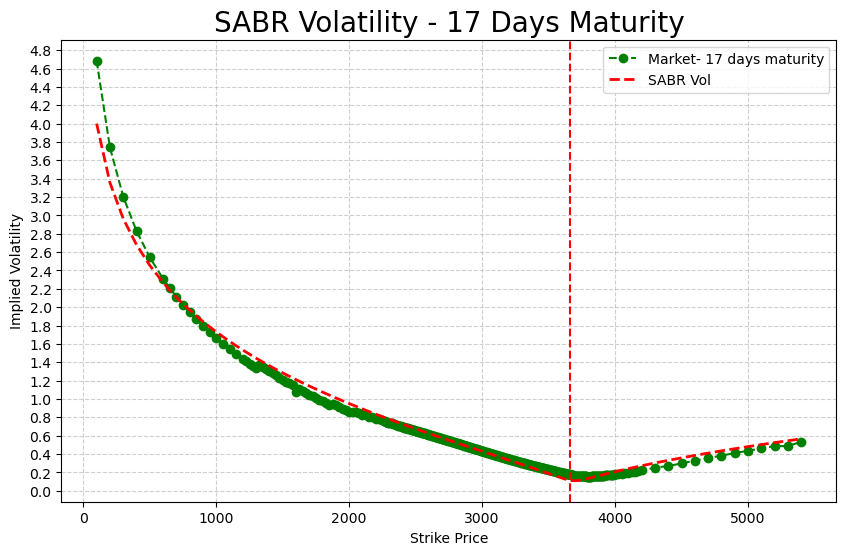

In [55]:
def plotSabrGraph(dd, T, SABR, color, marker, strike): 
    plt.figure(figsize=(10 , 6))
    plt.plot(dd['strike'], dd['impliedvol_market'], label=f"Market- {T} days maturity", linestyle='--', marker=marker, color=color)
    plt.plot(dd['strike'], SABR, '--', linewidth=2, color='red', label = 'SABR Vol')


    plt.title(f"SABR Volatility - {T} Days Maturity", fontsize = 20)
    plt.xlabel('Strike Price')
    plt.ylabel('Implied Volatility')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(loc='upper right')

    y_max = dd['impliedvol_market'].max()
    plt.yticks(np.arange(0, y_max+0.2, 0.2))
    # Add a vertical line
    plt.axvline(strike, color='red', linestyle='--')

    plt.show()
    
plotSabrGraph(dd_1, 17, SABR1, 'green', 'o', S)

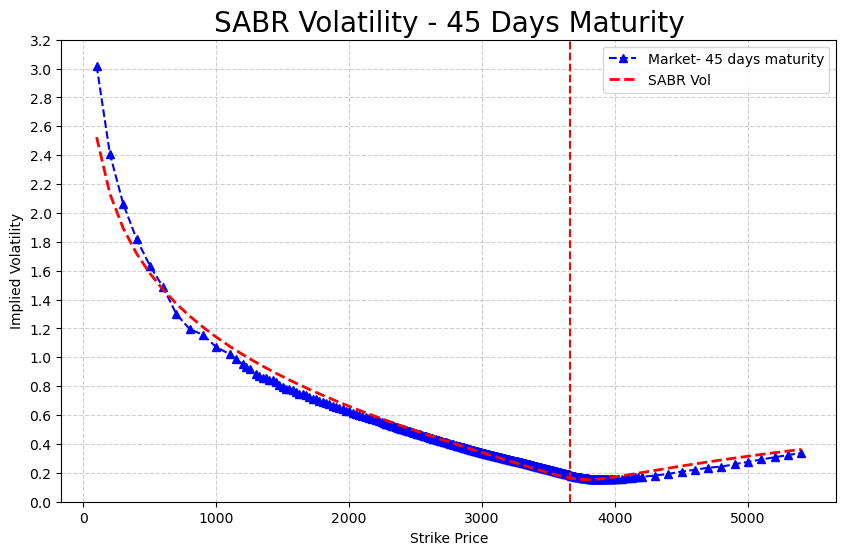

In [56]:
plotSabrGraph(dd_2, 45, SABR2, 'blue', '^', S)

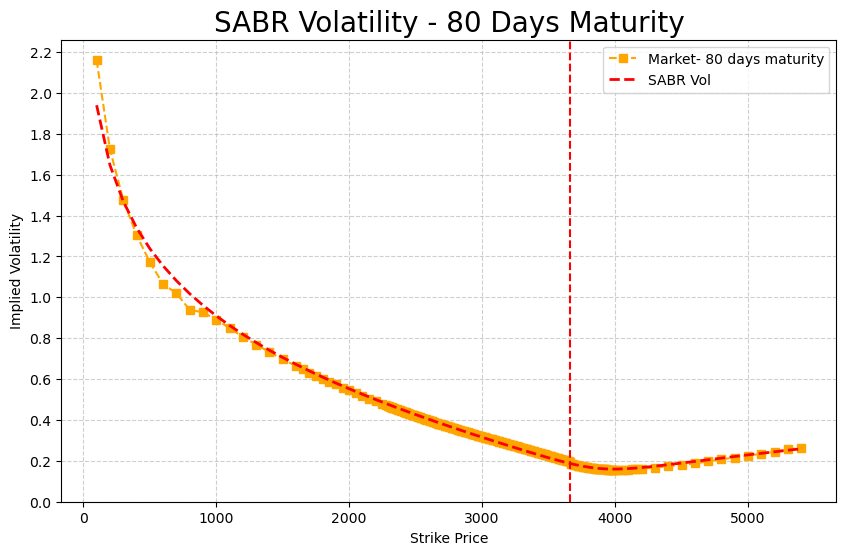

In [57]:
plotSabrGraph(dd_3, 80, SABR3, 'orange', 's', S)

# SPY data

In [58]:
# SPY General Data
spy_df = pd.read_csv('SPY_options.csv')
spy_df['strike_price'] = spy_df['strike_price']/1000
spy_df['mid_price'] = (spy_df['best_bid'] + spy_df['best_offer'])/2
S_A = 366.02
K_A = 366

# SPY Maturity Data
spy1 = spy_df[(spy_df.exdate == 20201218)]
spy2 = spy_df[(spy_df.exdate == 20210115)]
spy3 = spy_df[(spy_df.exdate == 20210219)]

## Binomial Tree Model

American Put Option:
The american_put function calculates the value of an American put option.
American options can be exercised at any time before or on the option's expiration date.
In the code, the loop for updating put_values and prices iterates in reverse order, allowing for early exercise at each step. At each time step, it checks if it's profitable to exercise the option or continue holding it.

European Put Option:
The european_put function calculates the value of a European put option.
European options can only be exercised at the expiration date.
In the code, the loop for updating put_values and prices also iterates in reverse order, but there is no check for early exercise. This is because European options can only be exercised at expiration, so the value at each step is based on the assumption of not being able to exercise early.

In summary, the primary difference between American and European put options in this code is the treatment of early exercise. The american_put function considers the possibility of early exercise at each step and updates the option's value accordingly, while the european_put function assumes that the option can only be exercised at expiration.

put_values[i] = max(put_values[i], (K-prices[i]))

In this line, it compares the value of the option if it were exercised (K - prices[i]) with the current calculated value (put_values[i]). If the value of exercising the option early is higher, it updates put_values[i] to be the higher value, effectively accounting for early exercise.

The max function ensures that the option's value is the maximum between the calculated value at that step and the immediate exercise value, making sure that the option holder will choose to exercise early if it's more profitable. This is what allows the code to model the behavior of an American option, where early exercise is possible if it's financially beneficial.

In [59]:
# Binomial Tree Model
def american_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
            put_values[i] = max(put_values[i], (K-prices[i]))
    return put_values[0]

def european_put(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    uu = u*u
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up
    prices = array.array('d', (0 for i in range(0, steps+1)))
    prices[0] = S*pow(d, steps)

    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    put_values = array.array('d', (0 for i in range(0, steps+1)))

    for i in range(0, steps+1):
        put_values[i] = max(0.0, (K-prices[i]))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            put_values[i] = (p_up*put_values[i+1]+p_down*put_values[i])/R
            prices[i] = d*prices[i+1]
    return put_values[0]

def american_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    prices = array.array('d', (0 for i in range(0, steps+1)))

    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]
            call_values[i] = max(call_values[i], 1.0*(prices[i]-K))

    return call_values[0]

def european_call(S, K, r, sigma, T, steps):
    R = (1+r)**(T/steps)
    u = np.exp(sigma*np.sqrt(T/steps))
    d = 1.0/u
    p_up = (R-d)/(u-d)
    p_down = 1.0-p_up

    # price of underlying
    prices = array.array('d', (0 for i in range(0, steps+1)))

    # fill in the endnodes
    prices[0] = S*pow(d, steps)
    uu = u*u
    for i in range(1, steps+1):
        prices[i] = uu*prices[i-1]

    call_values = array.array('d', (0 for i in range(0, steps+1)))
    for i in range(0, steps+1):
        call_values[i] = max(0.0, (prices[i]-K))

    for step in range(steps-1, -1, -1):
        for i in range(0, step+1):
            call_values[i] = (p_up*call_values[i+1]+p_down*call_values[i])/R
            prices[i] = d*prices[i+1]

    return call_values[0]

## American Options Implied Volatility

In [60]:
def calculate_option_values(spy, r, sigma, T, S):
    spy_call = spy[(spy.cp_flag == "C")].reset_index(drop=True)
    spy_put = spy[(spy.cp_flag == "P")].reset_index(drop=True)
    strikeA = spy_put["strike_price"].values

    summary = []
    for i in range(len(spy_put.index)):
        K = strikeA[i]
        if K <= int(S):
            AP = american_put(S, K, r, sigma, T, steps)
            EP = european_put(S, K, r, sigma, T, steps)
        elif K > int(S):
            AP = american_call(S, K, r, sigma, T, steps)
            EP = european_call(S, K, r, sigma, T, steps)     

        summary.append([K, AP, EP])

    option_df = pd.DataFrame(summary, columns=['strike', 'AP', 'EP'])
    option_df['Premium'] = option_df['AP'] - option_df['EP']
    
    spy_put['mid_price_stripped'] = spy_put['mid_price'] - option_df['Premium']
    spy_call['mid_price_stripped'] = spy_call['mid_price'] - option_df['Premium']
    
    return option_df, spy_call, spy_put

A1_T, spy_call1, spy_put1 = calculate_option_values(spy1, r1, sigma1, T1, S_A)

A2_T, spy_call2, spy_put2 = calculate_option_values(spy2, r2, sigma2, T2, S_A)

A3_T, spy_call3, spy_put3 = calculate_option_values(spy3, r3, sigma3, T3, S_A)

In [61]:
A1_T = A1_T.sort_values(by="Premium", ascending=False)

A1_T

,strike,AP,EP,Premium
197,366.0,5.440592,5.440582,0.00001
196,365.0,5.021238,5.021227,0.00001
195,364.0,4.601883,4.601873,0.00001
194,363.0,4.182528,4.182518,0.00001
193,362.0,3.763174,3.763164,0.00001
...,...,...,...,...
90,259.0,0.000000,0.000000,0.00000
91,260.0,0.000000,0.000000,0.00000
92,261.0,0.000000,0.000000,0.00000
93,262.0,0.000000,0.000000,0.00000


In [62]:
def calculate_implied_vols_market(spy_call, spy_put, r, T):
    strikeA = spy_put["strike_price"].values
    summary = []
    for i in range(len(spy_put.index)):
        K = strikeA[i]
        if K <= int(S_A):
            impliedvol_market = impliedPutVolatility(S_A, K, r, spy_put['mid_price_stripped'][i], T)

        elif K > int(S_A):
            impliedvol_market = impliedCallVolatility(S_A, K, r, spy_call['mid_price_stripped'][i], T)

        summary.append([K, 
                          impliedvol_market,])

    implied_vol_df = pd.DataFrame(summary, columns=['strike', 
                                          'impliedvol_market',])
    return implied_vol_df

A1 = calculate_implied_vols_market(spy_call1, spy_put1, r1, T1)

A2 = calculate_implied_vols_market(spy_call2, spy_put2, r2, T2)

A3 = calculate_implied_vols_market(spy_call3, spy_put3, r3, T3)


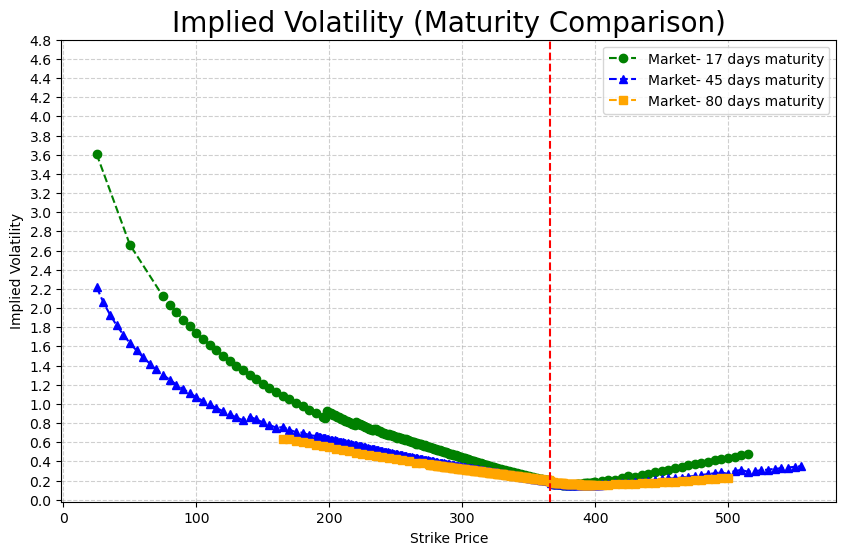

In [63]:
plt.figure(figsize=(10 , 6))
# plt.plot(dd_1['strike'],dd_1['impliedvol_market'],'k-',label='SPX (ExDate1)')
plt.plot(A1['strike'],A1['impliedvol_market'], label=f"Market- 17 days maturity", linestyle='--', marker='o', color='green')
# plt.plot(dd_2['strike'],dd_2['impliedvol_market'],'g-',label='SPX (ExDate2)')
plt.plot(A2['strike'],A2['impliedvol_market'], label=f"Market- 45 days maturity", linestyle='--', marker='^', color='blue')
# plt.plot(dd_3['strike'],dd_3['impliedvol_market'],'r-',label='SPX (ExDate3)')
plt.plot(A3['strike'],A3['impliedvol_market'], label=f"Market- 80 days maturity", linestyle='--', marker='s', color='orange')

plt.title('Implied Volatility (Maturity Comparison)', color = 'k', fontsize = 20)
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.grid(True, linestyle='--', alpha=0.6)

plt.yticks(np.arange(0,5, 0.2))

# Add a vertical line
plt.axvline(S_A, color='red', linestyle='--')


plt.legend()
plt.show()

In [64]:
strikeA1 = A1_T["strike"]
strikeA2 = A2_T["strike"]
strikeA3 = A3_T["strike"]

In [65]:
# Calculate At The Money Volatility for different maturities
sigma_spy1 = calculate_atm_volatility(spy1, K_A, r1, S_A, T1)
sigma_spy2 = calculate_atm_volatility(spy2, K_A, r2, S_A, T2)
sigma_spy3 = calculate_atm_volatility(spy3, K_A, r3, S_A, T3)


In [66]:
sigma_spy1, sigma_spy2, sigma_spy3

(0.18668546784466106, 0.18479035576483496, 0.19103889494048198)

In [67]:
atm_spy_call1

NameError: name 'atm_spy_call1' is not defined

In [ ]:
spy1

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style,mid_price
0,20201201,20201218,C,25.0,340.74,341.20,A,340.970
1,20201201,20201218,C,50.0,315.75,316.21,A,315.980
2,20201201,20201218,C,75.0,290.75,291.21,A,290.980
3,20201201,20201218,C,80.0,285.75,286.21,A,285.980
4,20201201,20201218,C,85.0,280.75,281.21,A,280.980
...,...,...,...,...,...,...,...,...
505,20201201,20201218,P,495.0,130.25,130.71,A,130.480
506,20201201,20201218,P,500.0,135.25,135.71,A,135.480
507,20201201,20201218,P,505.0,140.25,140.70,A,140.475
508,20201201,20201218,P,510.0,145.25,145.70,A,145.475


In [ ]:
beta_values_spy = [beta1, beta2, beta3, beta4]

dd_spy_1 = calculate_implied_vols_dd(S_A, r1, T1, spy_call1, spy_put1, strikeA1, sigma_spy1, beta_values_spy)
dd_spy_2 = calculate_implied_vols_dd(S_A, r2, T2, spy_call2, spy_put2, strikeA2, sigma_spy2, beta_values_spy)
dd_spy_3 = calculate_implied_vols_dd(S_A, r3, T3, spy_call3, spy_put3, strikeA3, sigma_spy3, beta_values_spy)


In [ ]:
dd_spy_1

,strike,impliedvol_market,impliedvol_lognormal,impliedvol_normal,impliedvol_dd0.8,impliedvol_dd0.6,impliedvol_dd0.4,impliedvol_dd0.2
0,25.0,3.606650,0.000001,0.538045,0.000001,0.367247,0.429934,0.486144
1,50.0,2.660851,0.000001,0.430577,0.253367,0.305541,0.350945,0.392201
2,75.0,2.120563,0.000001,0.372298,0.234230,0.273926,0.309299,0.341827
3,80.0,2.035264,0.000001,0.363380,0.231469,0.269231,0.303022,0.334165
4,85.0,1.955287,0.186685,0.355097,0.228945,0.264908,0.297218,0.327062
...,...,...,...,...,...,...,...,...
250,495.0,0.424174,0.186685,0.159931,0.181537,0.176296,0.170955,0.165505
251,500.0,0.437078,0.186685,0.159089,0.181381,0.175979,0.170470,0.164845
252,505.0,0.449819,0.186685,0.158258,0.181228,0.175667,0.169993,0.164195
253,510.0,0.462401,0.186685,0.157438,0.181077,0.175359,0.169522,0.163554


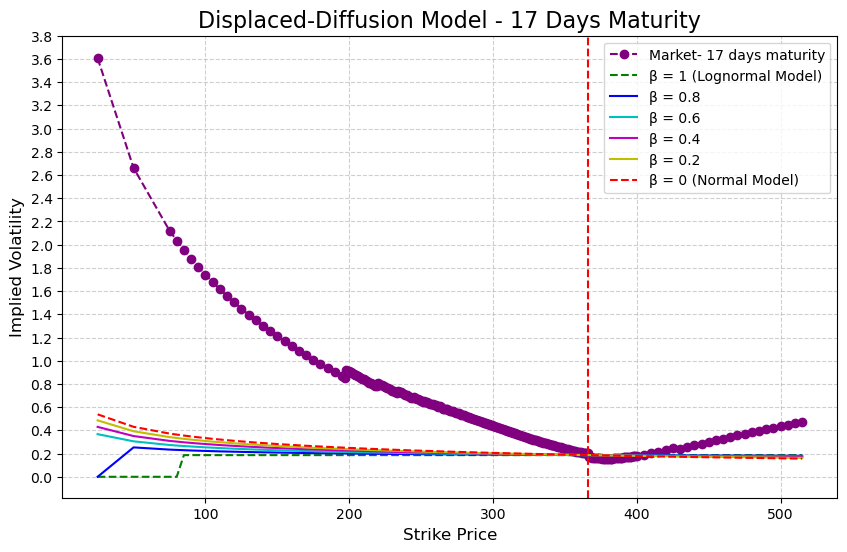

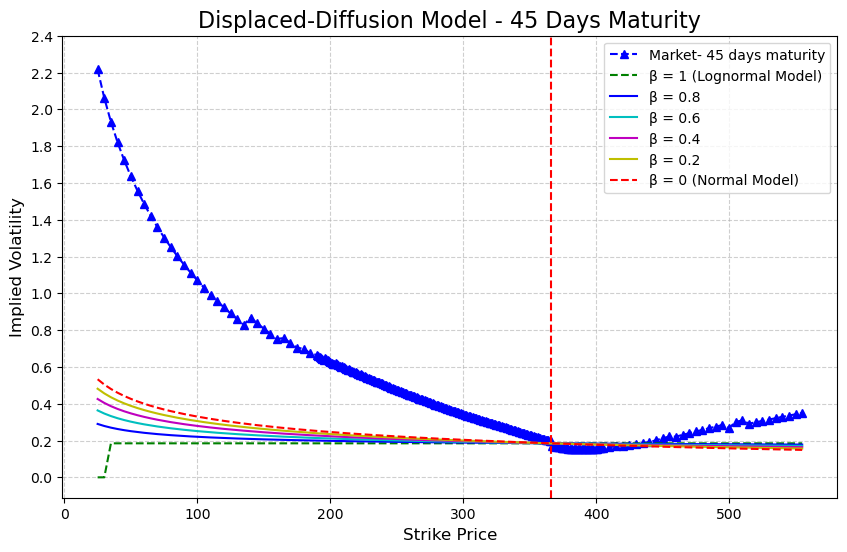

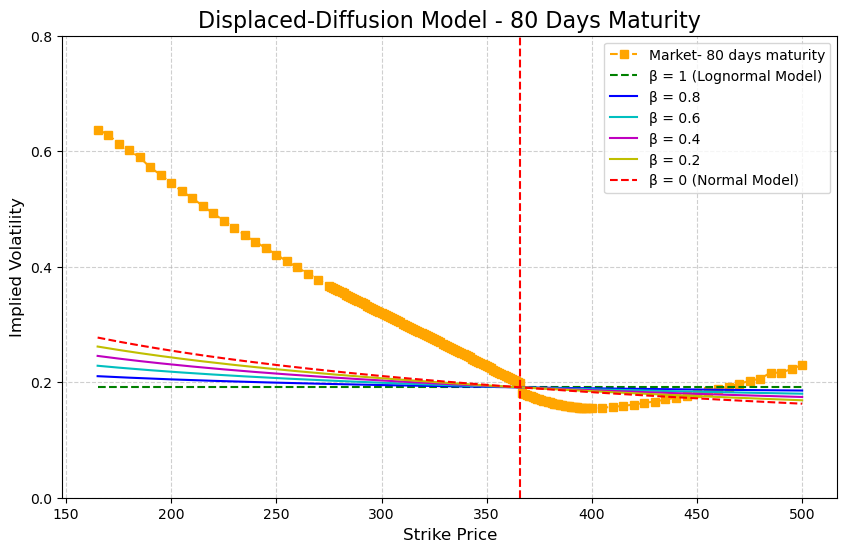

In [ ]:
plotDdGraph(dd_spy_1,17,'purple','o',S_A)
plotDdGraph(dd_spy_2,45,'blue','^',S_A)
plotDdGraph(dd_spy_3, 80, 'orange', 's',S_A)

In [ ]:

Fy1 = np.exp(r1 * T1) * S_A
alpha1_y, rho1_y, nu1_y, SABR1_y = sabr_calibration_and_volatility(dd_spy_1['strike'], dd_spy_1['impliedvol_market'], Fy1, T1, beta)

Fy2 = np.exp(r2 * T2) * S_A
alpha2_y, rho2_y, nu2_y, SABR2_y = sabr_calibration_and_volatility(dd_spy_2['strike'], dd_spy_2['impliedvol_market'], Fy2, T2, beta)

Fy3 = np.exp(r3 * T3) * S_A
alpha3_y, rho3_y, nu3_y, SABR3_y = sabr_calibration_and_volatility(dd_spy_3['strike'], dd_spy_3['impliedvol_market'], Fy3, T3, beta)


[ 0.66432178 -0.411423    5.25254876]
[ 0.90783421 -0.48729513  2.72885668]
[ 1.1209769  -0.62967153  1.74037763]


/var/folders/xs/s9d8jt1j4h9gq9f4s4p_v5t80000gp/T/ipykernel_4010/3075488719.py:21: RuntimeWarning: invalid value encountered in scalar power
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
/var/folders/xs/s9d8jt1j4h9gq9f4s4p_v5t80000gp/T/ipykernel_4010/3075488719.py:21: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


In [ ]:
SABR_params_data_y = {
    'SPY Maturity': ['17 days', '45 days', '80 days'],
    'Alpha': [alpha1_y, alpha2_y, alpha3_y],
    'Rho': [rho1_y, rho2_y, rho3_y],
    'Nu': [nu1_y, nu2_y, nu3_y]
}

sabr_parameters_y_df = pd.DataFrame(SABR_params_data_y)

sabr_parameters_y_df


,SPY Maturity,Alpha,Rho,Nu
0,17 days,0.664322,-0.411423,5.252549
1,45 days,0.907834,-0.487295,2.728857
2,80 days,1.120977,-0.629672,1.740378


In [ ]:
Fy1, Fy2, Fy3

(366.02021394703115, 366.020925564468, 366.02176996067533)

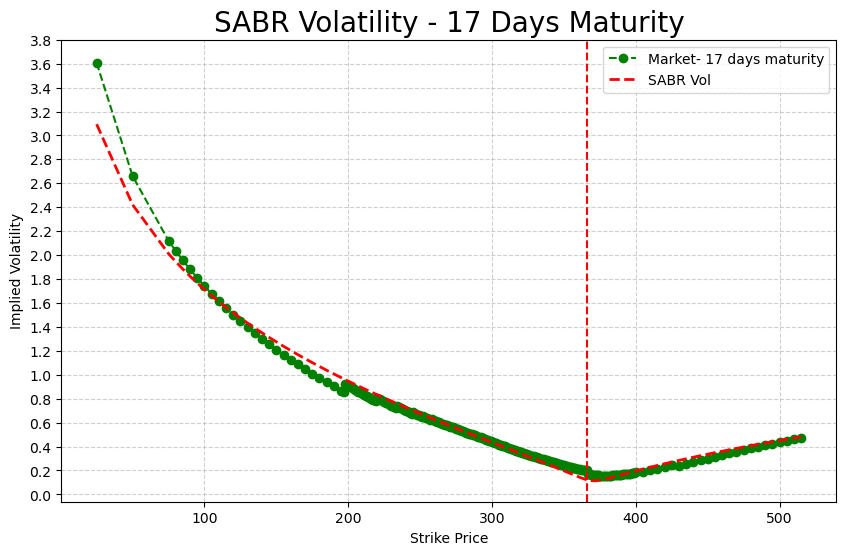

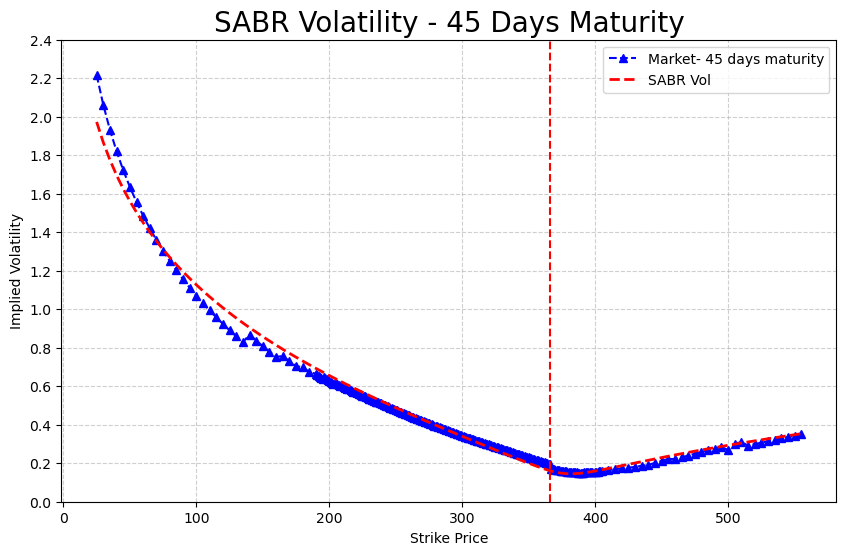

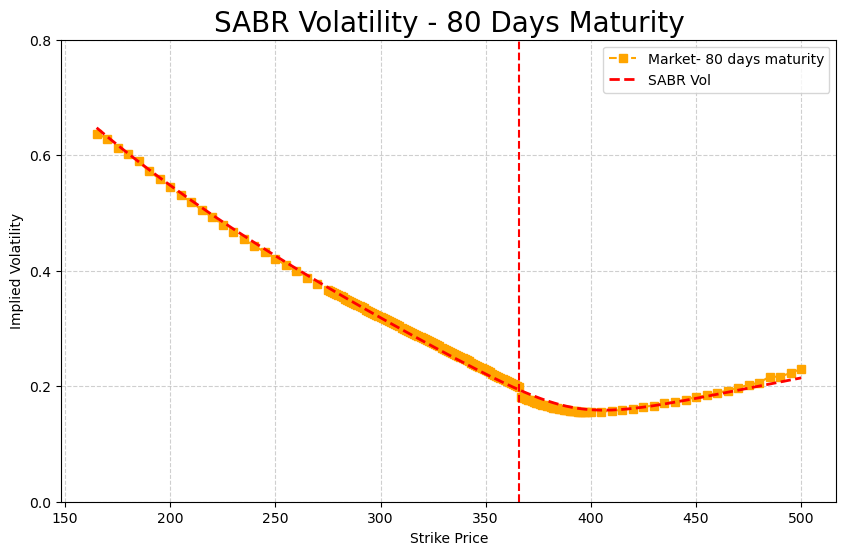

In [ ]:
plotSabrGraph(dd_spy_1, 17, SABR1_y, 'green', 'o', S_A)
plotSabrGraph(dd_spy_2, 45, SABR2_y, 'blue', '^', S_A)
plotSabrGraph(dd_spy_3, 80, SABR3_y, 'orange', 's', S_A)